In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from utils import make_confusion_matrix, plot_metrics, get_features

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline


In [18]:
df = pd.read_csv("./data/Notebook 1 Data/data.csv")
df.head()

,AGERNG,GENDER,EDU,PROF,MARSTS,RESDPL,LIVWTH,ENVSAT,POSSAT,FINSTR,DEBT,PHYEX,SMOKE,DRINK,ILLNESS,PREMED,EATDIS,AVGSLP,INSOM,TSSN,WRKPRE,ANXI,DEPRI,ABUSED,CHEAT,THREAT,SUICIDE,INFER,CONFLICT,LOST,DEPRESSED
0,26-30,Female,Post Graduate,Unemployed,Unmarried,Town,With Family,Yes,Yes,No,No,Sometimes,No,Yes,No,No,No,More than 8 hours,No,2-4 hours a day,No Pressure,Yes,No,No,No,No,No,No,Yes,No,0
1,26-30,Male,Post Graduate,Service holder (Private),Unmarried,City,With Family,Yes,No,Yes,No,Never,No,No,No,No,No,6 hours,Yes,5-7 hours a day,Moderate,Yes,Yes,Yes,No,No,No,Yes,No,No,1
2,21-25,Male,HSC,Student,Unmarried,City,With Family,Yes,Yes,No,No,Never,No,No,No,No,No,8 hours,No,8-10 hours a day,Mild,Yes,Yes,No,No,No,No,No,No,No,0
3,16-20,Male,HSC,Student,Unmarried,City,With Family,No,Yes,No,No,Sometimes,No,No,No,No,No,7 hours,No,2-4 hours a day,Severe,Yes,Yes,No,Yes,No,No,No,No,No,1
4,21-25,Male,Graduate,Student,Unmarried,Town,With Family,No,Yes,Yes,No,Never,No,No,No,Yes,No,7 hours,Yes,5-7 hours a day,Mild,Yes,Yes,No,No,No,No,Yes,Yes,No,1


In [21]:
df["DEPRESSED"].value_counts()

1    397
0    207
Name: DEPRESSED, dtype: int64

In [4]:
categorical_cols, numerical_cols, _ = get_features(df)

In [8]:
len(categorical_cols), len(numerical_cols)

(30, 1)

In [19]:
for cat in categorical_cols:
    en = LabelEncoder()
    en.fit(df[cat])
    print(cat, list(en.classes_))
    df[cat] = en.transform(df[cat])

AGERNG ['16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61+']
GENDER ['Female', 'Male']
EDU ['Graduate', 'HSC', 'Post Graduate', 'SSC']
PROF ['Businessman', 'Other', 'Service holder (Government)', 'Service holder (Private)', 'Student', 'Unemployed']
MARSTS ['Divorced', 'Married', 'Unmarried']
RESDPL ['City', 'Town', 'Village']
LIVWTH ['With Family', 'Without Family']
ENVSAT ['No', 'Yes']
POSSAT ['No', 'Yes']
FINSTR ['No', 'Yes']
DEBT ['No', 'Yes']
PHYEX ['Never', 'Regularly', 'Sometimes']
SMOKE ['No', 'Yes']
DRINK ['No', 'Yes']
ILLNESS ['No', 'Yes']
PREMED ['No', 'Yes']
EATDIS ['No', 'Yes']
AVGSLP ['5 hours', '6 hours', '7 hours', '8 hours', 'Below 5 hours', 'More than 8 hours']
INSOM ['No', 'Yes']
TSSN ['2-4 hours a day', '5-7 hours a day', '8-10 hours a day', 'Less than 2 hours', 'More than 10 hours a day']
WRKPRE ['Mild', 'Moderate', 'No Pressure', 'Severe']
ANXI ['No', 'Yes']
DEPRI ['No', 'Yes']
ABUSED ['No', 'Yes']
CHEAT ['No', 'Yes']
THREAT ['No'

In [20]:
df.head()

,AGERNG,GENDER,EDU,PROF,MARSTS,RESDPL,LIVWTH,ENVSAT,POSSAT,FINSTR,DEBT,PHYEX,SMOKE,DRINK,ILLNESS,PREMED,EATDIS,AVGSLP,INSOM,TSSN,WRKPRE,ANXI,DEPRI,ABUSED,CHEAT,THREAT,SUICIDE,INFER,CONFLICT,LOST,DEPRESSED
0,2,0,2,5,2,1,0,1,1,0,0,2,0,1,0,0,0,5,0,0,2,1,0,0,0,0,0,0,1,0,0
1,2,1,2,3,2,0,0,1,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,1,0,0,1
2,1,1,1,4,2,0,0,1,1,0,0,0,0,0,0,0,0,3,0,2,0,1,1,0,0,0,0,0,0,0,0
3,0,1,1,4,2,0,0,0,1,0,0,2,0,0,0,0,0,2,0,0,3,1,1,0,1,0,0,0,0,0,1
4,1,1,0,4,2,1,0,0,1,1,0,0,0,0,0,1,0,2,1,1,0,1,1,0,0,0,0,1,1,0,1


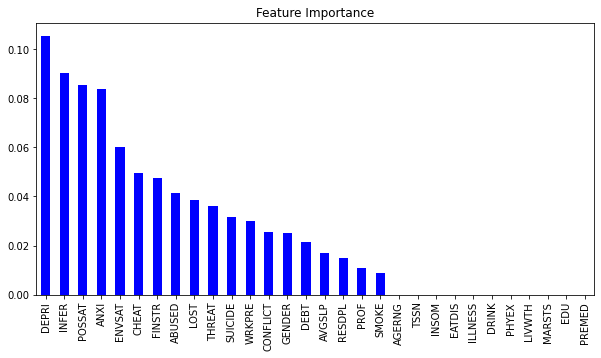

In [25]:
features = df.drop("DEPRESSED", axis=1)

mutual_info = mutual_info_classif(features, df["DEPRESSED"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = features.columns
plt.figure(figsize=(10, 5))
mutual_info.sort_values(ascending=False).plot.bar(color="b")
plt.title("Feature Importance")
plt.xticks(rotation=90)
plt.show()